<a href="https://colab.research.google.com/github/V4lciJr/Trasnfer-Learning-DIO/blob/main/Transfer_Learning_DIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferência de Aprendizado / Ajuste Fino
Este tutorial vai guiá-lo pelo processo de uso de transferência de aprendizado para aprender um classificador de imagens preciso a partir de um número relativamente pequeno de amostras de treinamento. De maneira geral, transferência de aprendizado refere-se ao processo de aproveitar o conhecimento aprendido em um modelo para treinar outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente que foi treinada com bom desempenho em um conjunto de dados maior e usá-la como base para um novo modelo, que aproveita a precisão do modelo anterior para uma nova tarefa. Este método se tornou popular nos últimos anos para melhorar o desempenho de uma rede neural treinada em um pequeno conjunto de dados; a intuição é que o novo conjunto de dados pode ser pequeno demais para ser treinado com bom desempenho por si só, mas sabemos que a maioria das redes neurais treinadas para aprender características de imagens acabam aprendendo características semelhantes, especialmente nas camadas iniciais, que são mais genéricas (detectores de borda, manchas, e assim por diante).

A transferência de aprendizado foi amplamente viabilizada pela publicação de modelos de última geração; para os modelos de melhor desempenho em tarefas de classificação de imagens (como o [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), é prática comum agora não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo. Isso permite que amadores usem esses classificadores de imagem de topo para melhorar o desempenho de seus próprios modelos específicos de tarefa.

## Extração de Características vs. Ajuste Fino

Em um extremo, a transferência de aprendizado pode envolver pegar a rede pré-treinada e congelar os pesos, usando uma de suas camadas ocultas (geralmente a última) como um extrator de características, utilizando essas características como entrada para uma rede neural menor.

No outro extremo, começamos com a rede pré-treinada, mas permitimos que alguns dos pesos (geralmente a última camada ou as últimas camadas) sejam modificados. Outro nome para este procedimento é "ajuste fino" (fine-tuning), porque estamos ajustando ligeiramente os pesos da rede pré-treinada para a nova tarefa. Normalmente, treinamos essa rede com uma taxa de aprendizado mais baixa, pois esperamos que as características já sejam relativamente boas e não precisem ser alteradas demais.

Às vezes, fazemos algo intermediário: congelamos apenas as camadas iniciais/genéricas e ajustamos as camadas finais. Qual estratégia é melhor depende do tamanho do seu conjunto de dados, do número de classes e de quão semelhante o conjunto de dados anterior é ao novo (e, portanto, se ele pode se beneficiar dos mesmos extratores de características aprendidos). Uma discussão mais detalhada sobre como decidir pode ser encontrada em [[1]](http://cs231n.github.io/transfer-learning/) [[2]](http://sebastianruder.com/transfer-learning/).

## Procedimento

Neste guia, vamos passar pelo processo de carregar um classificador de imagem de última geração, [VGG16](https://arxiv.org/pdf/1409.1556.pdf), que venceu o desafio ImageNet em 2014 [link](http://www.robots.ox.ac.uk/~vgg/research/very_deep), e usá-lo como um extrator de características fixo para treinar um classificador personalizado em nossas próprias imagens. No entanto, com poucas alterações de código, você pode tentar o ajuste fino também.

Vamos primeiro carregar o VGG16 e remover sua camada final, a camada softmax de 1000 classes específica para o ImageNet, substituindo-a por uma nova camada de classificação para as classes que estamos treinando. Em seguida, vamos congelar todos os pesos na rede, exceto os novos pesos que conectam à nova camada de classificação, e depois treinar essa nova camada de classificação em nosso novo conjunto de dados.

Como nosso conjunto de dados de teste, vamos usar um dataset com imagens de gatos e cachorros o famoso cats_and_dogs e treinar um classificador de imagens com cerca de 80% de precisão. Vale ressaltar que essa estratégia escala bem para conjuntos de imagens onde você pode ter até mesmo apenas algumas centenas de imagens ou menos. Seu desempenho será menor com um número pequeno de amostras (dependendo das classes), como de costume, mas ainda assim impressionante considerando as limitações habituais.



In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


_CITATION = """\
@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
year = {2007},
month = {October},
publisher = {Association for Computing Machinery, Inc.},
url = {https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/},
edition = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
}
"""

## Getting a dataset

In [2]:
# Configurações iniciais
batch_size = 32
image_size = (150, 150)
base_dir = "./datasets"  # Ajuste para o diretório em que você armazenará o dataset


In [3]:
# Download do dataset
if not os.path.exists(base_dir):
    tf.keras.utils.get_file(
        fname="cats_and_dogs.zip",
        origin="https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip",
        extract=True,
        cache_dir="./"
    )

824887076/824887076 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [4]:
# Diretórios de treino, validação e teste
train_dir = os.path.join(base_dir, 'PetImages')
dogs_dir = os.path.join(train_dir, 'Dog')
cats_dir = os.path.join(train_dir, 'Cat')

In [5]:
# Removendo arquivos corrompidos
num_skipped = 0
for folder_name in ("Dog", "Cat"):
    folder_path = os.path.join(train_dir, folder_name)
    print(folder_path)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            img = tf.keras.utils.load_img(fpath)
        except:
            num_skipped += 1
            os.remove(fpath)
print(f"Removidos {num_skipped} arquivos corrompidos.")

./datasets/PetImages/Dog


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


./datasets/PetImages/Cat
Removidos 4 arquivos corrompidos.


In [6]:
# Geradores de dados com augmentação
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [7]:
# Carregando o modelo base (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Construindo o modelo de Transfer Learning
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Treinando o modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


371/625 ━━━━━━━━━━━━━━━━━━━━ 1:00 238ms/step - accuracy: 0.7512 - loss: 0.5253

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 199s 298ms/step - accuracy: 0.7733 - loss: 0.4820 - val_accuracy: 0.8601 - val_loss: 0.3140
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 186s 289ms/step - accuracy: 0.8362 - loss: 0.3622 - val_accuracy: 0.8707 - val_loss: 0.2995
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 288ms/step - accuracy: 0.8508 - loss: 0.3319 - val_accuracy: 0.8715 - val_loss: 0.2905
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 289ms/step - accuracy: 0.8504 - loss: 0.3333 - val_accuracy: 0.8699 - val_loss: 0.2916
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 290ms/step - accuracy: 0.8557 - loss: 0.3210 - val_accuracy: 0.8677 - val_loss: 0.2981
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 294ms/step - accuracy: 0.8577 - loss: 0.3196 - val_accuracy: 0.8745 - val_loss: 0.2847
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 289ms/step - accuracy: 0.8711 - loss: 0.2968 - val_accuracy: 0.8705 - val_loss: 0.2899
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 290ms/step - accuracy: 0.8674 - loss: 0.30

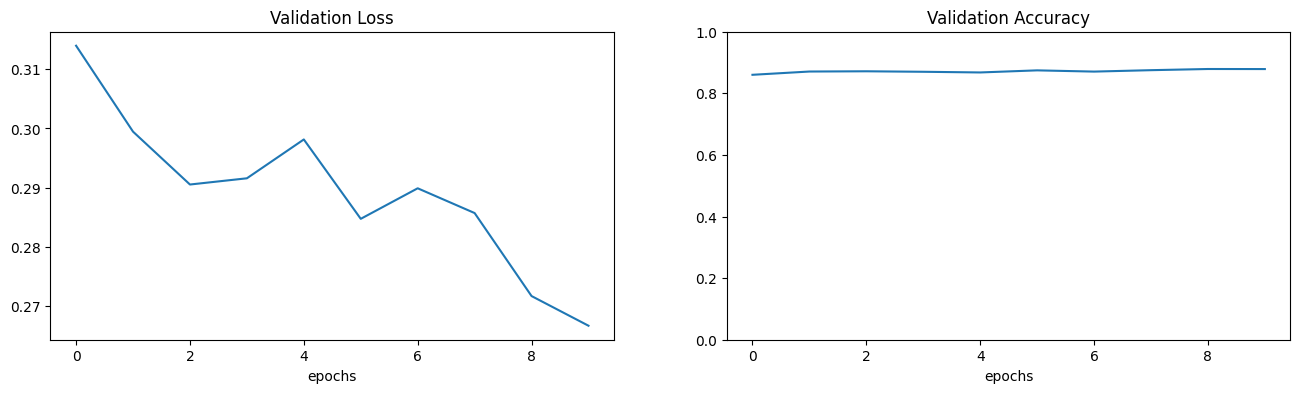

In [10]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validation Loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [11]:
# Avaliando o modelo
test_loss, test_accuracy = model.evaluate(validation_generator)
print('Test loss:', test_loss)
print(f"Test accuracy: {test_accuracy:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.8911 - loss: 0.2578
Test loss: 0.2657039165496826
Test accuracy: 0.89


In [12]:
# Salvando o modelo
model.save("cats_vs_dogs_transfer_learning.h5")